In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import itertools
from keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import shuffle

from PIL import Image
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
print ('modules loaded')

modules loaded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data_dir = '/content/drive/MyDrive/Plant Diseses/train-20220617T080745Z-001/train'
test_data_dir = '/content/drive/MyDrive/Plant Diseses/valid-20220617T081330Z-001/valid'

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 1983 images belonging to 4 classes.
Found 494 images belonging to 4 classes.
Found 1062 images belonging to 4 classes.


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 classes

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Found 1983 images belonging to 4 classes.
Epoch 1/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 1081s 8s/step - accuracy: 0.6927 - loss: 1.0772
Epoch 2/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 451s 4s/step - accuracy: 0.9055 - loss: 0.3224
Epoch 3/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.9554 - loss: 0.1925


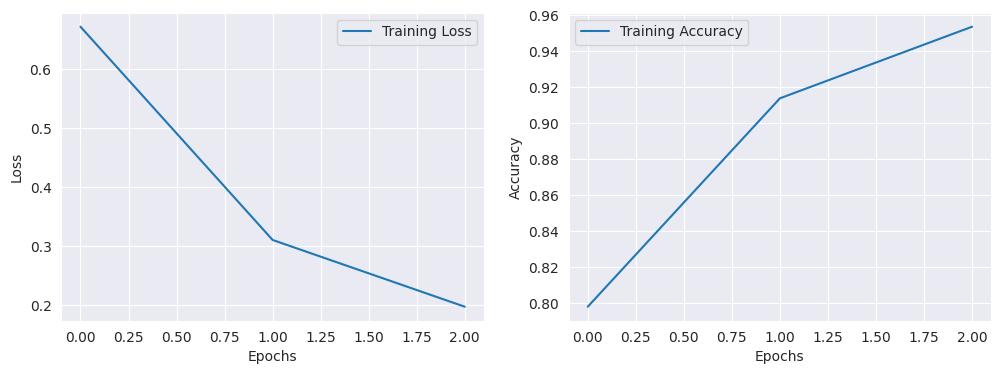

In [9]:
train_data_dir = '/content/drive/MyDrive/Plant Diseses/train-20220617T080745Z-001/train'
batch_size = 16
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 3  # You can adjust this as needed
history = model.fit(train_generator, epochs=epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
model.save('plant_disease_native_format.keras')




34/34 ━━━━━━━━━━━━━━━━━━━━ 703s 21s/step


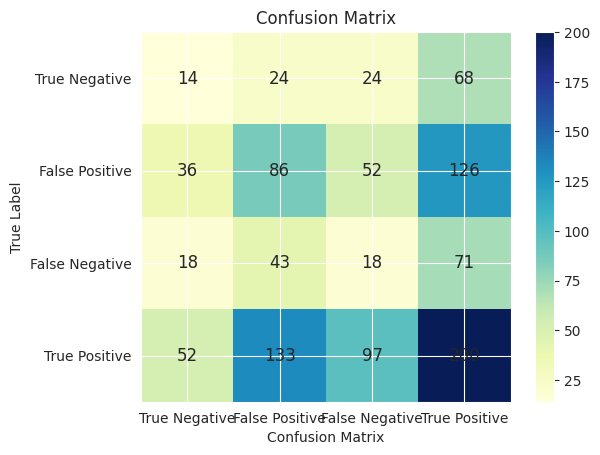

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns

# Assuming you have already defined 'predictions' and 'y_true'
predictions = model.predict(test_generator)
y_true = test_generator.classes
conf_matrix = metrics.confusion_matrix(y_true, np.argmax(predictions, axis=-1))

# Plot the confusion matrix with labeled quadrants and light colors
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('YlGnBu'))  # Using a light color map
ax.figure.colorbar(im, ax=ax)

# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

ax.set(xticks=np.arange(conf_matrix.shape[1]),
       yticks=np.arange(conf_matrix.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title='Confusion Matrix',
       ylabel='True Label',
       xlabel='Confusion Matrix')

# Annotate the confusion matrix cells with counts
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = ax.text(j, i, str(conf_matrix[i, j]), fontsize=12, ha='center', va='center')


plt.show()


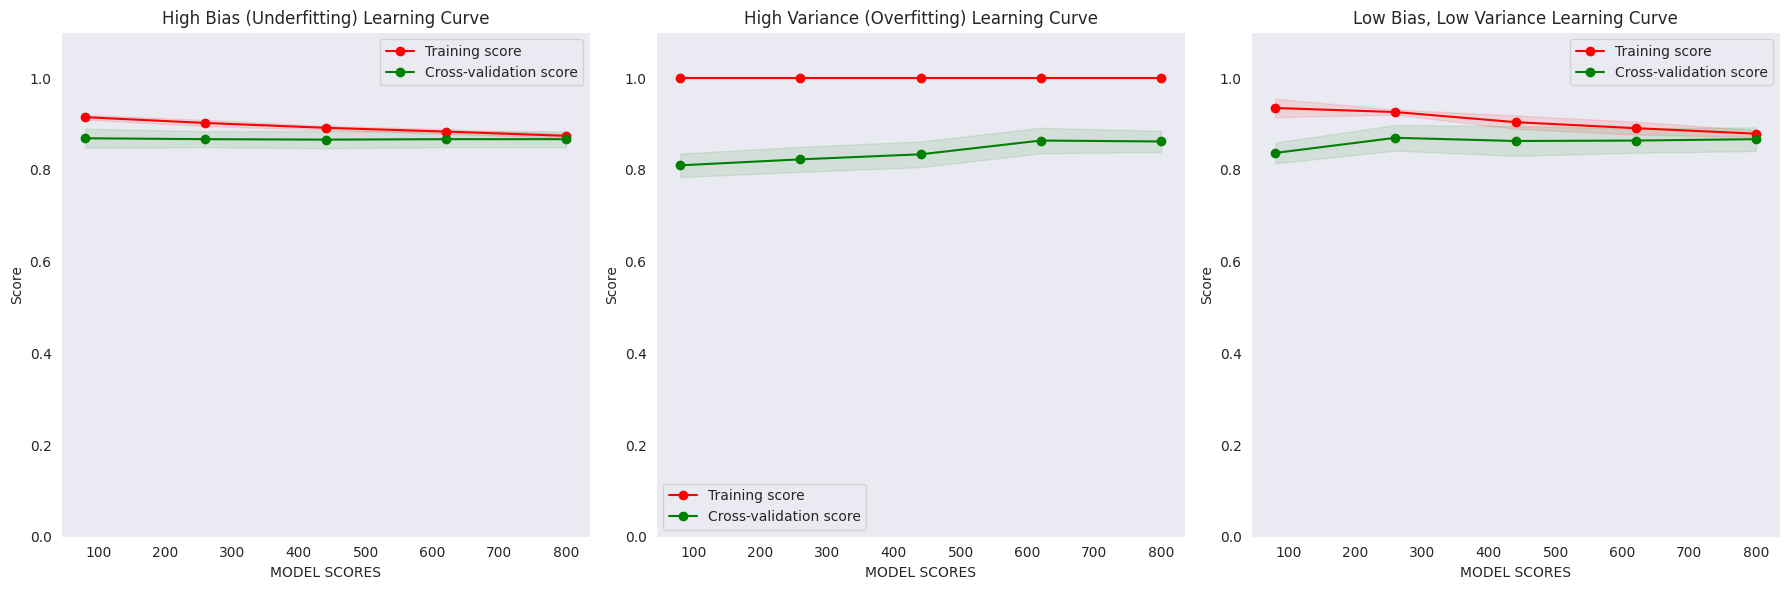

In [12]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

def plot_learning_curve(ax, estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("MODEL SCORES")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(accuracy_score))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.legend(loc="best")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

estimator_high_bias = DecisionTreeClassifier(max_depth=1, random_state=42)
estimator_high_variance = DecisionTreeClassifier(max_depth=None, random_state=42)
estimator_low_bias_variance = LogisticRegression(random_state=42)


title = "High Bias (Underfitting) Learning Curve"
plot_learning_curve(axes[0], estimator_high_bias, title, X, y, ylim=(0, 1.1), cv=5, n_jobs=-1)

title = "High Variance (Overfitting) Learning Curve"
plot_learning_curve(axes[1], estimator_high_variance, title, X, y, ylim=(0, 1.1), cv=5, n_jobs=-1)

title = "Low Bias, Low Variance Learning Curve"
plot_learning_curve(axes[2], estimator_low_bias_variance, title, X, y, ylim=(0, 1.1), cv=5, n_jobs=-1)

plt.tight_layout()
plt.show()

In [13]:
batch_size = 16
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_data_dir = '/content/drive/MyDrive/Plant Diseses/train-20220617T080745Z-001/train'
valid_data_dir = '/content/drive/MyDrive/Plant Diseses/valid-20220617T081330Z-001/valid'

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

images, labels = next(train_gen)

g_dict = train_gen.class_indices
classes = list(g_dict.keys())

num_images_to_display = 16

plt.figure(figsize=(12, 12))

for i in range(num_images_to_display):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image.astype(int))
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_images_by_class(class_name, num_images=50):
    class_dir = os.path.join(train_data_dir, class_name)
    class_images = os.listdir(class_dir)

    if len(class_images) == 0:
        print(f"No images found for class: {class_name}")
        return

    random.shuffle(class_images)

    num_rows = 5
    num_cols = 10

    plt.figure(figsize=(20, 10))
    plt.suptitle(f"Images for Plant Type: {class_name}", fontsize=16)

    for i in range(min(num_images, len(class_images))):
        image_name = class_images[i]
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert("RGB")

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(image_name, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

user_input = input("Enter the name of the image class: ")
show_images_by_class(user_input, num_images=50)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
import sklearn.externals as extjoblib
import joblib
import pickle
joblib.dump(model, 'cnn_kyc.pkl')

['cnn_kyc.pkl']

In [19]:
cnn_from_joblib = joblib.load('cnn_kyc.pkl')

file = open("cnn_kyc.pkl",'rb')
object_file = pickle.load(file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


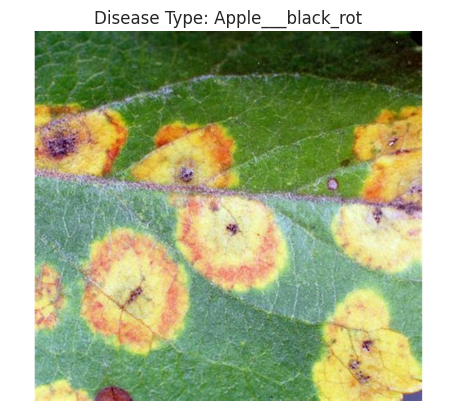

In [20]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#loaded_model = tf.keras.models.load_model('C:/project/Plant Diseases/plant_disease_native_format.keras')

classes = ['Apple___Apple_scab','Apple___black_rot','Apple___Cedar_apple_rust','Apple___healthy']

input_folder = '/content/drive/MyDrive/Plant Diseses/test'

for filename in os.listdir(input_folder):
    if filename.endswith('.jpeg'):
        img_path = os.path.join(input_folder, filename)

        img = image.load_img(img_path, target_size=(150, 150))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0

        prediction = object_file.predict(img)
        class_index = np.argmax(prediction)
        class_label = classes[class_index]
        img = image.load_img(img_path)
        plt.figure()
        plt.imshow(img)
        plt.title(f"Disease Type: {class_label}")
        plt.axis('off')
        plt.show()

In [24]:
remedial_actions = {
    0: "Apple Scab: Use fungicides like Captan or Mancozeb, and improve air circulation around trees.",
    1: "Black Rot: Apply copper-based fungicides and remove infected branches.",
    2: "Cedar Apple Rust: Use fungicides like Myclobutanil and avoid planting near juniper trees.",
    3: "Healthy: No remedial action required."
}
remedy = remedial_actions[class_index]
print("Remedial Solution: ", remedy)

Remedial Solution:  Black Rot: Apply copper-based fungicides and remove infected branches.
